<a href="https://colab.research.google.com/github/rodrigodemend/Previsao_Covid/blob/main/Notebooks/Previs%C3%A3o_das_mortes_por_Covid_19_usando_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando todas as bibliotecas

In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#Importando os dados limpos

In [2]:
data_new_deaths = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Cleaned/data_new_deaths.csv', encoding='utf-8')
data_new_deaths.tail()

,date,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
660,2021-12-16,0.0,2.0,3.0,0.0,4.0,4.0,3.0,2.0,0.0,2.0,24.0,0.0,2.0,12.0,0.0,6.0,2.0,4.0,5.0,7.0,4.0,2.0,17.0,9.0,0.0,0.0,0.0
661,2021-12-17,0.0,2.0,0.0,0.0,7.0,0.0,7.0,13.0,0.0,3.0,19.0,0.0,5.0,6.0,0.0,10.0,6.0,1.0,0.0,2.0,2.0,0.0,12.0,10.0,0.0,259.0,0.0
662,2021-12-18,0.0,1.0,0.0,0.0,2.0,7.0,0.0,1.0,0.0,2.0,17.0,0.0,0.0,1.0,7.0,5.0,0.0,2.0,30.0,0.0,2.0,0.0,5.0,4.0,1.0,51.0,0.0
663,2021-12-19,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,15.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,7.0,3.0,1.0,0.0,4.0,5.0,0.0,0.0,0.0
664,2021-12-20,0.0,2.0,0.0,1.0,6.0,10.0,3.0,11.0,0.0,3.0,1.0,0.0,3.0,7.0,2.0,4.0,4.0,2.0,2.0,0.0,7.0,0.0,2.0,2.0,1.0,0.0,0.0


#Funções utilizadas no notebook

In [15]:
def prophet_model(df, parameters=None):
  """
  Função criada para facilitar a criação do modelo com novos parâmetros e teste com cross validation
  """
  if parameters != None:
    modelo = Prophet(**parameters)
  else:
    modelo = Prophet()
  modelo.fit(df)
  df_cv = cross_validation(modelo, initial='400 days', period='30 days', horizon='30 days')
  return performance_metrics(df_cv)

In [80]:
def best_result(df, grid, parameter):
  """
  Esta função retorna o melhor resultado 
  """
  return grid[int(df.mean().sort_values().head(1).index[0])][parameter]  

# Visualização dos dados

In [5]:
estado = 'SC'

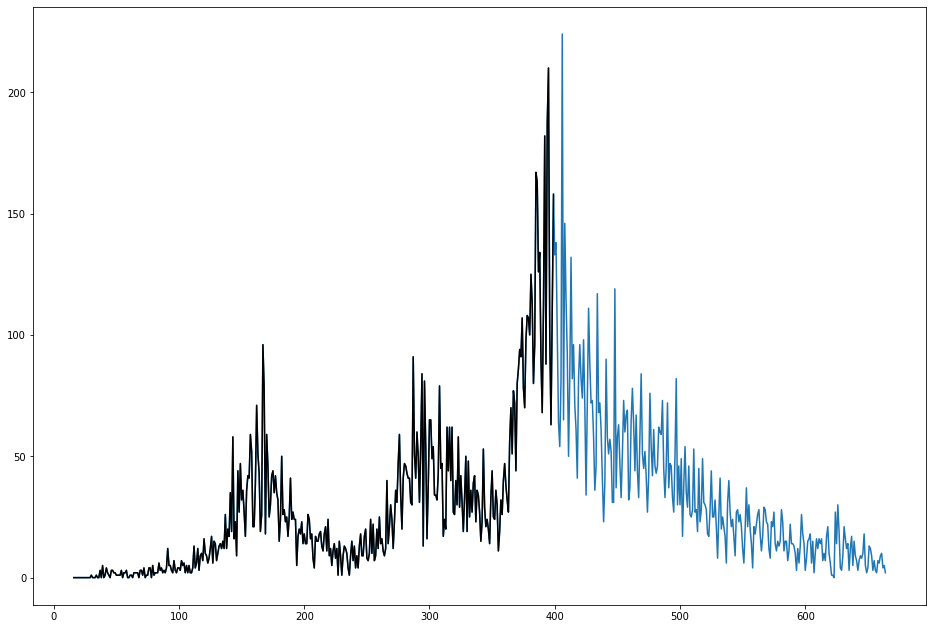

In [6]:
data_new_deaths[estado].plot(figsize=(16,11))
data_new_deaths[estado][:400].plot(figsize=(16,11), color='black')

In [7]:
data_new_deaths[estado].describe()

count    649.000000
mean      31.018490
std       32.198453
min        0.000000
25%        9.000000
50%       21.000000
75%       43.000000
max      224.000000
Name: SC, dtype: float64

## Modelo básico Prophet

In [8]:
df = pd.DataFrame()
df['ds'] = data_new_deaths['date']
df['y'] = data_new_deaths[estado].values

In [9]:
df_p = prophet_model(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [10]:
print("Média MAE:", df_p['mae'].mean()) 
print("Média RMSE:", df_p['rmse'].mean())

Média MAE: 21.599716541393395
Média RMSE: 28.938175969140595


# Otimizando a tendência

Criando os dataframes para salvar os resultados dos experimentos da tendência

In [17]:
MAE_results_exp_trend = pd.DataFrame()
RMSE_results_exp_trend = pd.DataFrame()

## 1° Experimento de tendência

Fazendo uma otimização do parâmetro "changepoint_prior_scale" com os "n_changepoints" gerados automáticamente pelo prophet 

In [39]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import ParameterGrid
params_grid = {'n_changepoints':[i for i in range(5, 55, 5)],
              'changepoint_prior_scale':[i/1000 for i in range(1, 500, 20)]}
grid = ParameterGrid(params_grid)

MAE = pd.DataFrame()
RMSE = pd.DataFrame()

enable = False
if enable:
  for i in range(len(grid)):
    print('======================= '+str(i)+' ====================================')
    V1_modelo = Prophet(**grid[i])
    V1_modelo.fit(df)
    V1_df_cv = cross_validation(V1_modelo, initial='400 days', period='30 days', horizon='30 days')
    V1_df_p = performance_metrics(V1_df_cv)
    MAE[str(i)] = V1_df_p['mae']
    RMSE[str(i)] = V1_df_p['rmse']

else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Other_Results/MAE.csv', sep=';')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Other_Results/RMSE.csv', sep=';')

Arrendondando os resultados de MAE e RMSE

In [13]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

Salvando os resultados de MAE e RMSE

In [14]:
MAE.to_csv('/content/MAE.xlsx', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.xlsx', sep=',',  index=False)

Achando os melhores resultados do primeiro experimento para o MAE e para o RMSE

###n_changepoints

In [81]:
best_result(df=MAE, grid=grid, parameter='n_changepoints')

50

In [82]:
best_result(df=RMSE, grid=grid, parameter='n_changepoints')

10

De acordo com os resultados do MAE e RMSE foi escolhido o valor de n_changepoints = 50

###changepoint_prior_scale

In [83]:
best_result(df=MAE, grid=grid, parameter='changepoint_prior_scale')

0.461

In [84]:
best_result(df=RMSE, grid=grid, parameter='changepoint_prior_scale')

0.041

Escolhendo o valor de changepoint_prior_scale=0.461

FAZER............

Visualizando os changepoints

Testando forma de crescimento linear e exponencial

Salvando os resultados do primeiro experimento

In [87]:
param = {'n_changepoints':50,
         'changepoint_prior_scale':0.461}

results = prophet_model(df, parameters=param)
MAE_results_exp_trend['1° Exp'] = results['mae']
RMSE_results_exp_trend['1° Exp'] = results['rmse']

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [88]:
print("Resultados do primeiro experimento - MAE: ", MAE_results_exp_trend['1° Exp'].mean())
print("Resultados do primeiro experimento - RMSE: ", RMSE_results_exp_trend['1° Exp'].mean())

Resultados do primeiro experimento - MAE:  18.350858459072104
Resultados do primeiro experimento - RMSE:  30.369618177493887


## 2° Experimento de tendência